<a href="https://colab.research.google.com/github/prashantmalan/MarketRisk/blob/main/FRTM_Internal_Model_Approach_Step_by_Step.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FRTB Internal Model Approach (IMA) Analysis
## Executive Dashboard

This notebook demonstrates the implementation of FRTB IMA calculations for our trading portfolio, including risk metrics, capital charges, and regulatory compliance tests.

### Portfolio Overview

* S&P 500 Futures: \$10M (Long)
* EURO STOXX 50 Futures: €8M (Short)

* US 10-Year Treasury Futures: $5M (Long)

In [16]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from datetime import datetime

# Set basic matplotlib style instead of seaborn
plt.style.use('default')
# Set figure aesthetics
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

### 1. Portfolio Risk Configuration
Defining our portfolio parameters and risk settings according to FRTB guidelines.

In [17]:
class PortfolioConfig:
    def __init__(self):
        self.positions = {
            'SP500': {
                'value': 10_000_000,
                'horizon': 10,
                'description': 'S&P 500 Futures Long'
            },
            'EUROSTOXX': {
                'value': 8_800_000,
                'horizon': 10,
                'description': 'EURO STOXX 50 Futures Short'
            },
            'US_TREASURY': {
                'value': 5_000_000,
                'horizon': 20,
                'description': 'US 10Y Treasury Futures Long'
            }
        }
        self.confidence_level = 0.975
        self.base_horizon = 10
        self.stress_multiplier = 2.92

# Initialize configuration
config = PortfolioConfig()

# Display portfolio summary
df_portfolio = pd.DataFrame(config.positions).T
print("Portfolio Configuration:")
display(df_portfolio)

Portfolio Configuration:


,value,horizon,description
SP500,10000000,10,S&P 500 Futures Long
EUROSTOXX,8800000,10,EURO STOXX 50 Futures Short
US_TREASURY,5000000,20,US 10Y Treasury Futures Long


### 2. Risk Calculation Engine
Implementation of core FRTB IMA calculations including Expected Shortfall and liquidity horizon adjustments.

In [18]:
class FRTBCalculator:
    def __init__(self, config):
        self.config = config

    def generate_market_data(self, n_days=250):
        data = {}
        for asset in self.config.positions:
            if asset == 'SP500':
                data[asset] = np.random.normal(0.0001, 0.01, n_days)
            elif asset == 'EUROSTOXX':
                data[asset] = np.random.normal(0.0001, 0.012, n_days) * 0.7 + \
                            np.random.normal(0, 0.01, n_days) * 0.3
            else:
                data[asset] = np.random.normal(0, 0.005, n_days)
        return pd.DataFrame(data)

    def calculate_ES(self, returns):
        sorted_returns = np.sort(returns)
        cutoff = int(len(returns) * (1 - self.config.confidence_level))
        return -np.mean(sorted_returns[:cutoff])

    def adjust_liquidity_horizon(self, es_base, target_horizon):
        return es_base * np.sqrt(target_horizon/self.config.base_horizon)

# Initialize calculator and generate market data
calculator = FRTBCalculator(config)
market_data = calculator.generate_market_data()

### 3. Risk Metrics Dashboard
Visualization of key risk metrics and capital requirements.

<ipython-input-19-2ac4ecf26bca>:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(es_components.keys(), rotation=45)


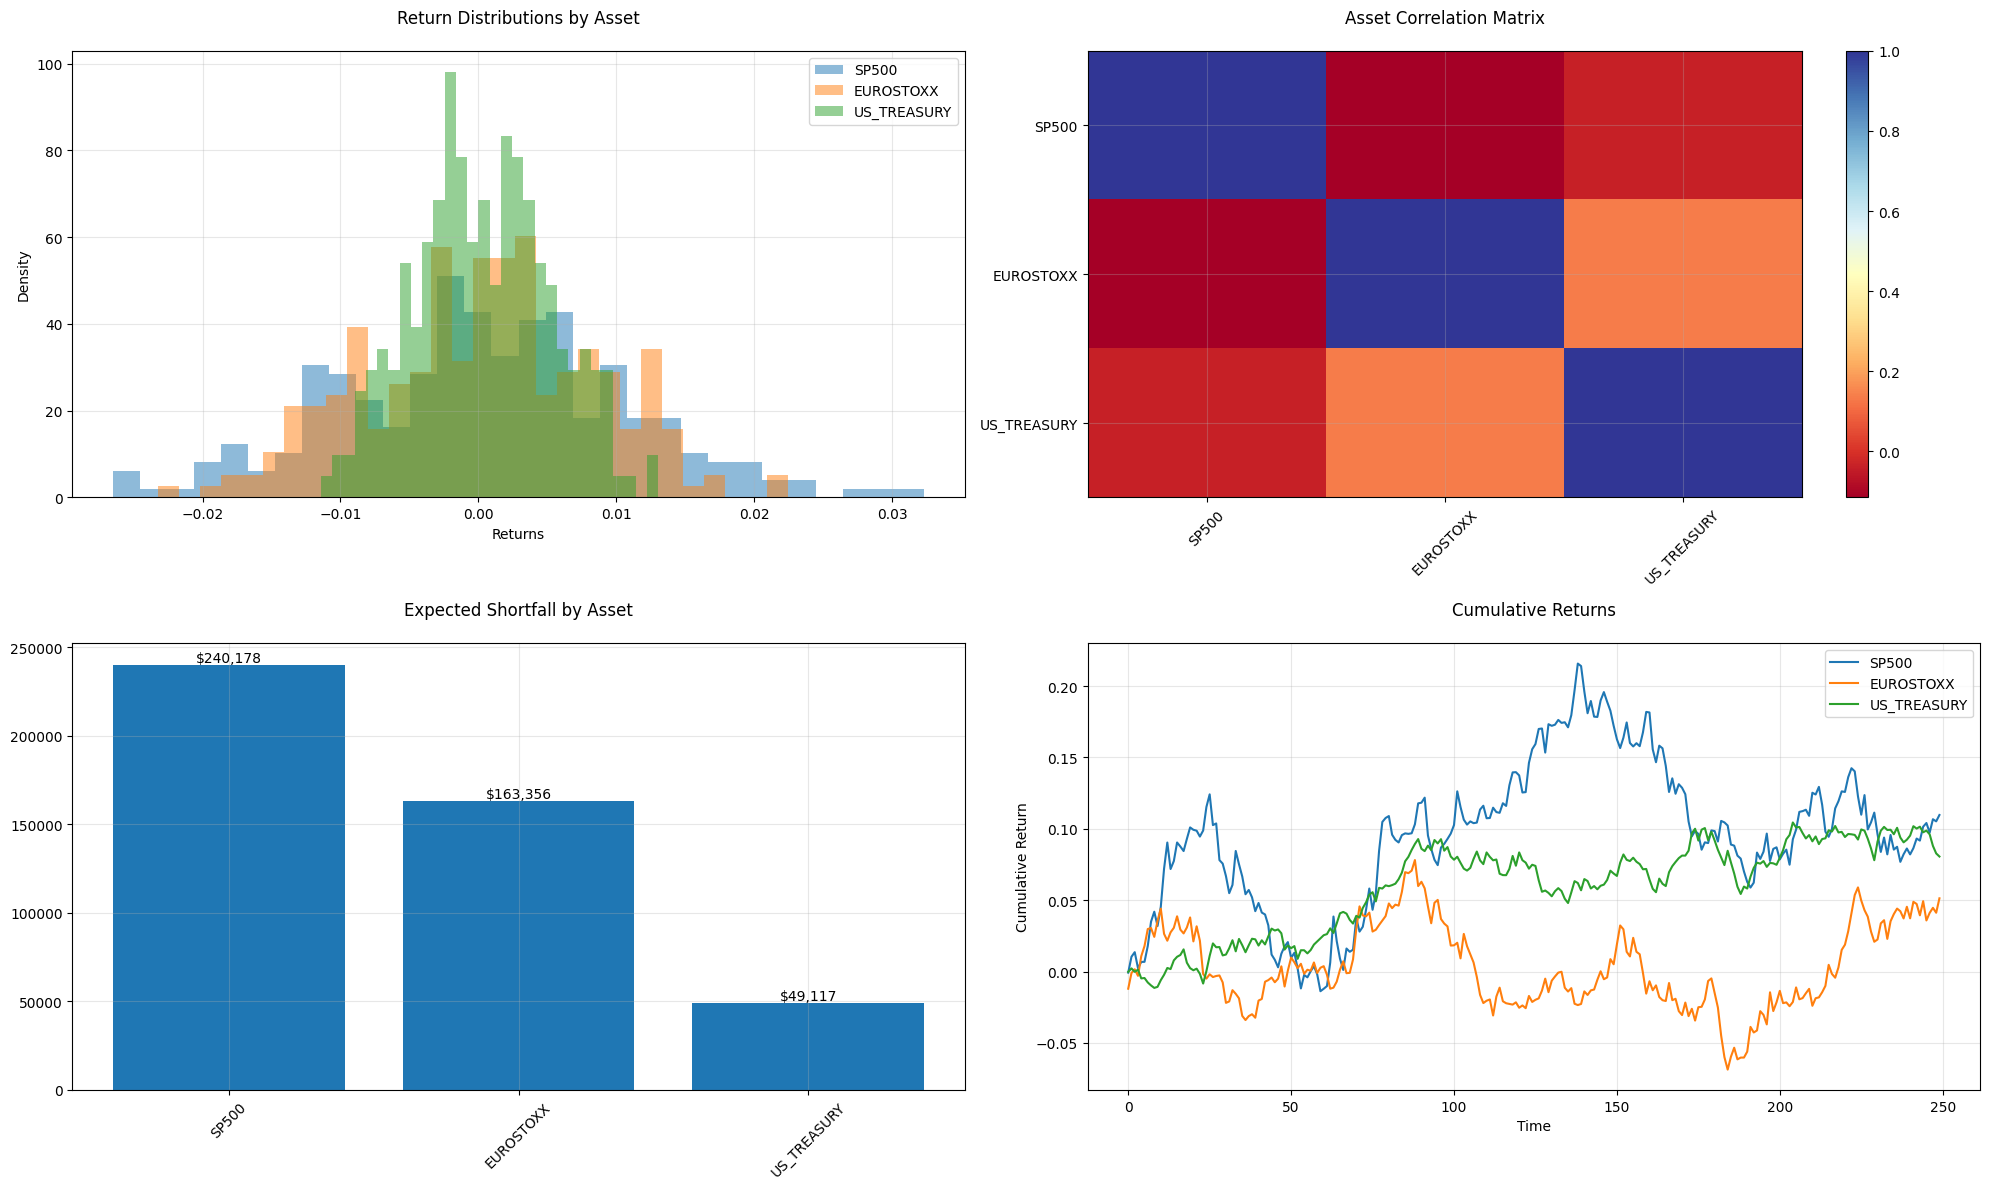

In [19]:
def create_risk_dashboard(market_data, calculator):
    fig = plt.figure(figsize=(20, 12))

    # Returns Distribution
    ax1 = plt.subplot(2, 2, 1)
    for col in market_data.columns:
        ax1.hist(market_data[col], bins=30, alpha=0.5, label=col, density=True)
    ax1.set_title('Return Distributions by Asset', fontsize=12, pad=20)
    ax1.set_xlabel('Returns')
    ax1.set_ylabel('Density')
    ax1.legend()

    # Correlation Matrix
    ax2 = plt.subplot(2, 2, 2)
    correlation = market_data.corr()
    im = ax2.imshow(correlation, cmap='RdYlBu', aspect='auto')
    ax2.set_xticks(range(len(correlation.columns)))
    ax2.set_yticks(range(len(correlation.columns)))
    ax2.set_xticklabels(correlation.columns, rotation=45)
    ax2.set_yticklabels(correlation.columns)
    plt.colorbar(im)
    ax2.set_title('Asset Correlation Matrix', fontsize=12, pad=20)

    # ES Components
    ax3 = plt.subplot(2, 2, 3)
    es_components = {
        asset: calculator.calculate_ES(market_data[asset]) * config.positions[asset]['value']
        for asset in market_data.columns
    }
    bars = ax3.bar(es_components.keys(), es_components.values())
    ax3.set_title('Expected Shortfall by Asset', fontsize=12, pad=20)
    ax3.set_xticklabels(es_components.keys(), rotation=45)

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'${height:,.0f}',
                ha='center', va='bottom')

    # Time Series
    ax4 = plt.subplot(2, 2, 4)
    cumulative_returns = market_data.cumsum()
    for col in cumulative_returns:
        ax4.plot(cumulative_returns.index, cumulative_returns[col], label=col)
    ax4.set_title('Cumulative Returns', fontsize=12, pad=20)
    ax4.set_xlabel('Time')
    ax4.set_ylabel('Cumulative Return')
    ax4.legend()

    plt.tight_layout()
    plt.show()

# Create and display risk dashboard
create_risk_dashboard(market_data, calculator)

### 4. Capital Charge Calculation
Final capital requirements based on FRTB IMA methodology.

In [21]:
def calculate_capital_requirements():
    # Calculate base ES for each position
    base_es = {}
    for asset in market_data.columns:
        es = calculator.calculate_ES(market_data[asset])
        position_value = config.positions[asset]['value']
        horizon = config.positions[asset]['horizon']
        es_adjusted = calculator.adjust_liquidity_horizon(es * position_value, horizon)
        base_es[asset] = es_adjusted

    # Calculate total ES
    total_es = np.sqrt(sum([es**2 for es in base_es.values()]))
    stressed_es = total_es * config.stress_multiplier
    capital_charge = max(stressed_es, stressed_es * 1.5)

    # Convert base_es to a list for consistent data structure
    base_es_list = [base_es[asset] for asset in market_data.columns]

    results = pd.DataFrame({
        'Base ES': base_es_list,  # Use base_es_list here
        'Total ES': [total_es] * len(base_es_list),  # Use len(base_es_list)
        'Stressed ES': [stressed_es] * len(base_es_list),  # Use len(base_es_list)
        'Capital Charge': [capital_charge] * len(base_es_list)  # Use len(base_es_list)
    }, index=market_data.columns)  # Set index to asset names

    return results

### 5. Regulatory Compliance Tests
Results of P&L attribution and backtesting requirements.

In [22]:
def run_regulatory_tests(market_data):
    # P&L Attribution Test
    theoretical_pl = market_data.sum(axis=1)
    actual_pl = theoretical_pl + np.random.normal(0, theoretical_pl.std()*0.1, len(theoretical_pl))

    correlation_ratio = np.corrcoef(theoretical_pl, actual_pl)[0,1]
    variance_ratio = np.var(theoretical_pl) / np.var(actual_pl)

    # Backtesting
    var_99 = np.percentile(theoretical_pl, 1)
    exceptions = sum(actual_pl < var_99)

    results = pd.DataFrame({
        'Metric': ['P&L Correlation Ratio', 'P&L Variance Ratio', 'VaR Exceptions'],
        'Value': [correlation_ratio, variance_ratio, exceptions],
        'Threshold': ['> 0.8', '0.8 - 1.2', '< 12'],
        'Status': [
            'PASS' if correlation_ratio > 0.8 else 'FAIL',
            'PASS' if 0.8 <= variance_ratio <= 1.2 else 'FAIL',
            'PASS' if exceptions < 12 else 'FAIL'
        ]
    })

    return results

# Run regulatory tests
regulatory_results = run_regulatory_tests(market_data)
display(regulatory_results)

,Metric,Value,Threshold,Status
0,P&L Correlation Ratio,0.995335,> 0.8,PASS
1,P&L Variance Ratio,0.996565,0.8 - 1.2,PASS
2,VaR Exceptions,3.000000,< 12,PASS


In [25]:
# Generate Executive Summary
capital_results = calculate_capital_requirements() # Call the function to calculate and assign to capital_results
sum_individual_es = sum(capital_results['Base ES'])
total_es = capital_results['Total ES'].iloc[0]
diversification_benefit = (1 - total_es/sum_individual_es) * 100

print("## Executive Summary")
print("\n### Key Findings:")
print(f"1. Capital Requirements")
print(f"   - Total Capital Charge: ${capital_results['Capital Charge'].iloc[0]:,.2f}")
print(f"   - Stress Buffer: {(config.stress_multiplier - 1)*100:.0f}%")
print(f"\n2. Risk Profile")
print(f"   - Largest ES contribution from: {capital_results['Base ES'].idxmax()}")
print(f"   - Diversification benefit: {diversification_benefit:.1f}%")
print(f"\n3. Regulatory Compliance")
print(f"   - P&L Attribution: {regulatory_results.iloc[0]['Status']}")
print(f"   - Backtesting: {regulatory_results.iloc[2]['Status']}")
print(f"\n### Recommendations:")
print("1. Continue monitoring correlation assumptions")
print("2. Review liquidity horizon calibrations")
print("3. Enhance stress scenario coverage")
print(f"4. Focus on {capital_results['Base ES'].idxmax()} risk management given highest ES contribution")

## Executive Summary

### Key Findings:
1. Capital Requirements
   - Total Capital Charge: $1,308,114.76
   - Stress Buffer: 192%

2. Risk Profile
   - Largest ES contribution from: SP500
   - Diversification benefit: 36.9%

3. Regulatory Compliance
   - P&L Attribution: PASS
   - Backtesting: PASS

### Recommendations:
1. Continue monitoring correlation assumptions
2. Review liquidity horizon calibrations
3. Enhance stress scenario coverage
4. Focus on SP500 risk management given highest ES contribution
